<a href="https://colab.research.google.com/github/Mai-Fakhry/Optical-character-recognition-OCR-/blob/main/NoteBooks/OCR_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

Optical Character Recognition (OCR) is a fundamental task in computer vision that aims to automatically identify and convert images of printed or handwritten text into machine-readable characters. It has wide applications in document digitization, license plate recognition, bank cheque processing, assistive technologies, and many other real-world systems.

This notebook presents a complete pipeline for developing an OCR system for alphanumeric character recognition. The workflow includes:


*   downloading and preparing the dataset
*   preprocessing input images


*   extracting discriminative features using Histogram of Oriented Gradients (HOG)
*   training machine learning classifiers

*   evaluating performance using standard metrics and visualizations

By the end of this notebook, we obtain a trained model capable of recognizing uppercase letters, lowercase letters, and digits from image samples. The methodology emphasizes clarity, reproducibility, and practical implementation suitable for academic study and real-world applications.

# **Repository Cloning**
[Repositry Link](https://github.com/Mai-Fakhry/Optical-character-recognition-OCR-)

In [ ]:
!git clone https://github.com/Mai-Fakhry/Optical-character-recognition-OCR-

Cloning into 'Optical-character-recognition-OCR-'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 45 (delta 12), reused 15 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 91.75 KiB | 1.43 MiB/s, done.
Resolving deltas: 100% (12/12), done.


# **Kaggle API Installation**

In [ ]:
!pip install kaggle

In [ ]:
!ls /content

kaggle.json  Optical-character-recognition-OCR-  sample_data  template


1. Create the hidden .kaggle directory in the user’s home folder

2. Copy the kaggle.json credential file into this directory

3. Set appropriate file permissions to protect the API key

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# **Downloading the OCR Dataset from Kaggle**

In [ ]:
!kaggle datasets download -d harieh/ocr-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/harieh/ocr-dataset
License(s): CC0-1.0
100% 153M/153M [00:00<00:00, 1.60GB/s]
100% 153M/153M [00:00<00:00, 1.60GB/s]




*   os, zipfile, shutil – file and directory management
*   IL, cv2 – image loading and preprocessing


*   numpy, pandas – numerical and tabular data manipulation
*   hog from skimage.feature – feature extraction using Histogram of Oriented Gradients


*   sklearn modules – model training, testing, and performance evaluation
*   matplotlib, seaborn – data visualization and plotting

In [ ]:
import os
import zipfile
import shutil
from PIL import Image
import numpy as np
import cv2
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# **Extracting the Dataset Files**

In [ ]:
zip_path = "/content/Optical-character-recognition-OCR-/Datasets/template.zip"
extract_path = "/content"


os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Extracted to:", extract_path)
print("Contents:", os.listdir(extract_path))

Extracted to: /content
Contents: ['.config', 'dataset', 'template', 'Optical-character-recognition-OCR-', 'kaggle.json', 'sample_data']


# **Defining Dataset Directories and Character Classes**

In [ ]:
template_dir = "/content/template/uppercase"
dataset_dir = "/content/dataset"
import string

uppercase_letters = list(string.ascii_uppercase)
lowercase_letters = list(string.ascii_lowercase)
digits = [str(i) for i in range(10)]


# **Image Preprocessing Function**

This function performs preprocessing on input character images to prepare them for feature extraction and classification. It converts images to grayscale, applies adaptive thresholding to binarize them, crops the character region, pads it to a square shape, and resizes it to a fixed resolution. The output is a normalized image suitable for use in OCR models.

In [ ]:
def preprocess_image(img, size=(40, 60)):
    if img is None:
        return None

    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_bin = cv2.adaptiveThreshold(
        img,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        15,
        3
    )

    coords = cv2.findNonZero(img_bin)
    if coords is None:
        return None

    x, y, w, h = cv2.boundingRect(coords)
    cropped = img_bin[y:y+h, x:x+w]
    if cropped.size == 0:
        return None


    h_c, w_c = cropped.shape
    max_side = max(h_c, w_c)
    pad_vert = (max_side - h_c) // 2
    pad_horz = (max_side - w_c) // 2
    cropped_padded = cv2.copyMakeBorder(
        cropped,
        pad_vert,
        max_side - h_c - pad_vert,
        pad_horz,
        max_side - w_c - pad_horz,
        cv2.BORDER_CONSTANT,
        value=0
    )

    resized = cv2.resize(cropped_padded, size)
    return resized / 255.0



# **HOG Feature Extraction**
This function computes Histogram of Oriented Gradients (HOG) features from a preprocessed image. HOG captures the edge and gradient structure of the character, providing a compact numerical representation that is highly effective for character recognition tasks.

In [ ]:
def extract_hog(img):
    features = hog(
        img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys'
    )
    return features


# **Dataset Loading and Feature Extraction**

In this section, we construct the feature matrix and labels from the OCR dataset. For each character category—uppercase letters, lowercase letters, and digits—the code iterates through the corresponding folders, loads each image, applies preprocessing, and extracts HOG features. The extracted feature vectors are stored in X, while their associated character labels are stored in y. Finally, the total number of samples and distinct classes are displayed to verify successful dataset loading.

In [ ]:
X = []
y = []

dataset_dir = "/content/dataset"

# --- Uppercase ---
for char in uppercase_letters:
    folder = os.path.join(dataset_dir, f"{char}_U")
    if not os.path.exists(folder):
        continue
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        processed = preprocess_image(img)
        if processed is None:
            continue
        X.append(extract_hog(processed))
        y.append(char)

# --- Lowercase ---
for char in lowercase_letters:
    folder = os.path.join(dataset_dir, f"{char}_L")
    if not os.path.exists(folder):
        continue
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        processed = preprocess_image(img)
        if processed is None:
            continue
        X.append(extract_hog(processed))
        y.append(char)

# --- Digits ---
for digit in digits:
    folder = os.path.join(dataset_dir, digit)
    if not os.path.exists(folder):
        continue
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        processed = preprocess_image(img)
        if processed is None:
            continue
        X.append(extract_hog(processed))
        y.append(digit)

X = np.array(X)
y = np.array(y)

print("Total samples:", len(X))
print("Total classes:", len(np.unique(y)))
print("Classes:", np.unique(y))


Total samples: 209679
Total classes: 62
Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


# **Visualizing Class Distribution**

This section visualizes the number of samples available for each character class in the dataset. The bar plot helps identify whether the dataset is balanced or if certain classes have significantly more or fewer samples than others.

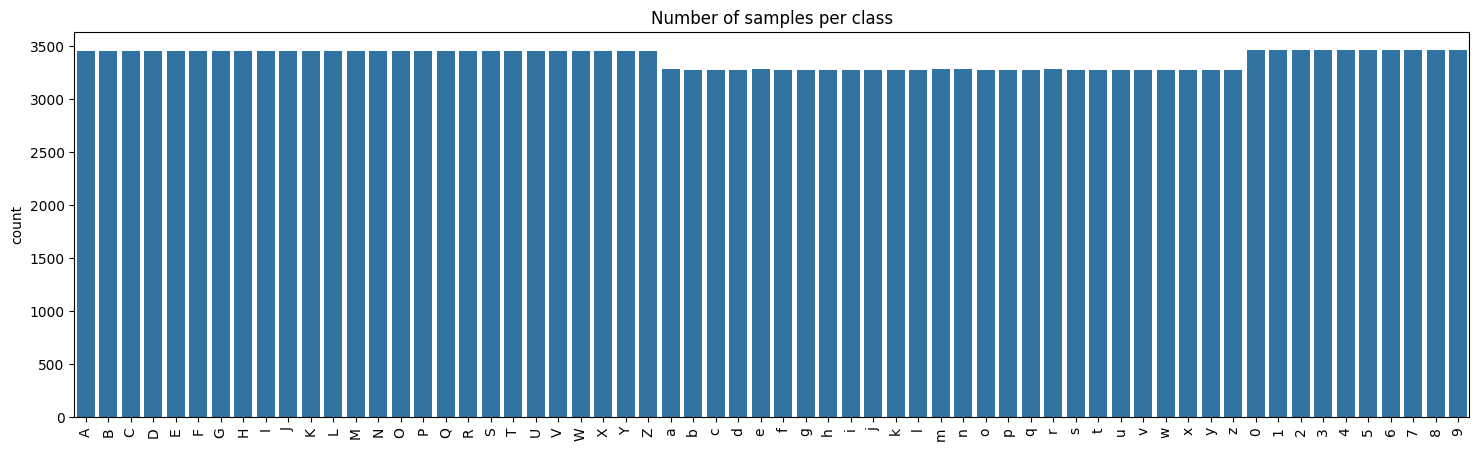

In [ ]:
#Class distribution
plt.figure(figsize=(18,5))
sns.countplot(x=y)
plt.xticks(rotation=90)
plt.title("Number of samples per class")
plt.show()

# **Splitting the Dataset into Training and Testing Sets**

The dataset is divided into training and testing subsets to evaluate model performance objectively. We use an 80/20 split while preserving the class distribution through stratified sampling. The training set is used to fit the models, and the test set is reserved for evaluating their generalization ability.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# **Training the Linear SVM Classifier**

In this step, we train a Linear Support Vector Machine (SVM) classifier using the extracted HOG features. The model is fitted on the training data and learns a decision boundary for distinguishing between the different character classes.

In [ ]:
svm_model = LinearSVC(C=1.0, max_iter=5000)
svm_model.fit(X_train, y_train)


LinearSVC(max_iter=5000)

# **Model Evaluation on the Test Set**

After training the SVM classifier, we evaluate its performance on the unseen test data. The model predicts the class labels for the test samples, and we compute the overall accuracy as well as a detailed classification report, including precision, recall, and F1-score for each class.

In [ ]:
y_pred = svm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.866010110644792
              precision    recall  f1-score   support

           0       0.68      0.67      0.67       693
           1       0.90      0.86      0.88       693
           2       0.95      0.94      0.95       693
           3       0.86      0.94      0.90       693
           4       0.97      0.94      0.95       693
           5       0.97      0.92      0.95       693
           6       0.97      0.94      0.95       693
           7       0.93      0.94      0.93       693
           8       0.95      0.93      0.94       693
           9       0.91      0.94      0.93       693
           A       0.90      0.89      0.89       691
           B       0.93      0.93      0.93       691
           C       0.84      0.77      0.80       691
           D       0.88      0.91      0.90       691
           E       0.92      0.88      0.90       691
           F       0.90      0.90      0.90       691
           G       0.88      0.90      0.89       691

# **Confusion Matrix Visualization**

To gain deeper insight into the model’s performance, we compute and visualize z confusion matrix. The matrix shows how often each true class is correctly or incorrectly classified as another class. By inspecting this heatmap, we can identify classes that are frequently misclassified and better understand model strengths and weaknesses.

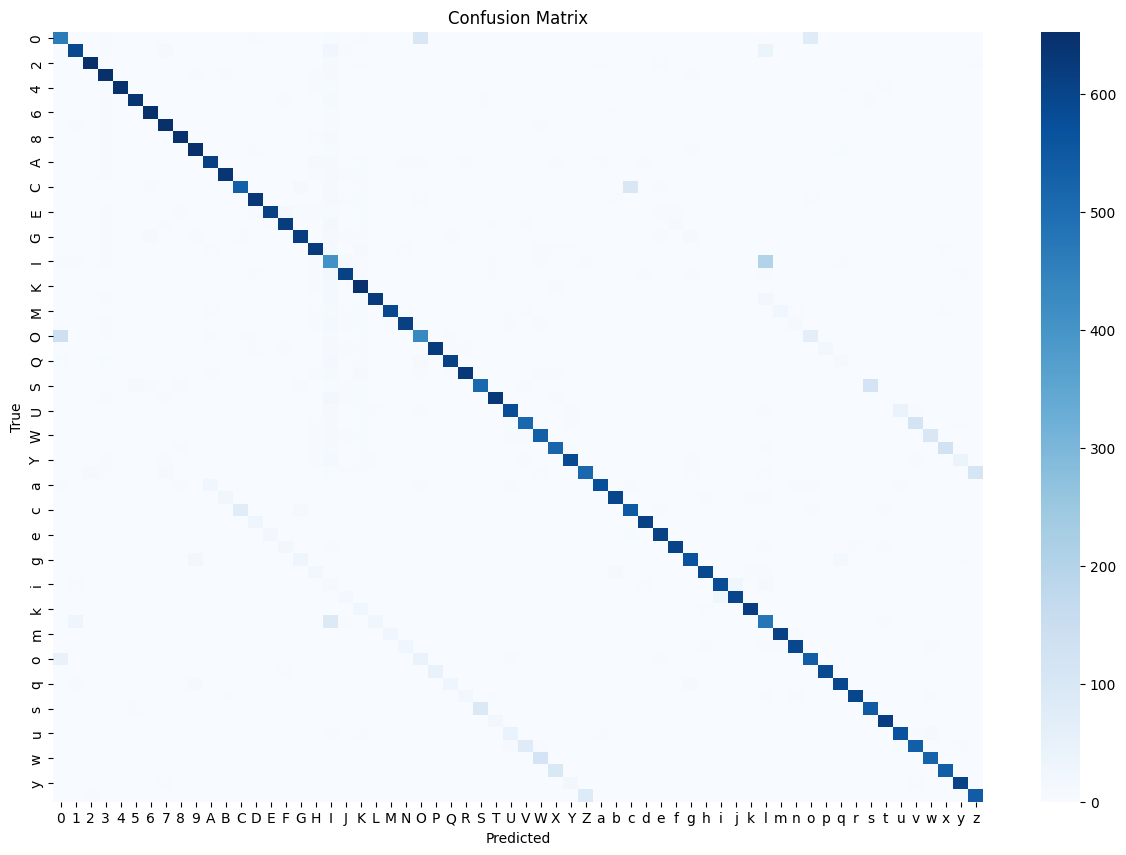

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
cm_df = pd.DataFrame(cm, index=np.unique(y), columns=np.unique(y))

plt.figure(figsize=(15,10))
sns.heatmap(cm_df, annot=False, cmap="Blues", fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# **Visualizing Sample Predictions**

In this section, we display a set of random samples from the test dataset along with their predicted labels. For each selected character image, the true label and the label predicted by the trained model are shown. This qualitative visualization helps illustrate how the model performs on real examples and highlights cases of correct and incorrect recognition.

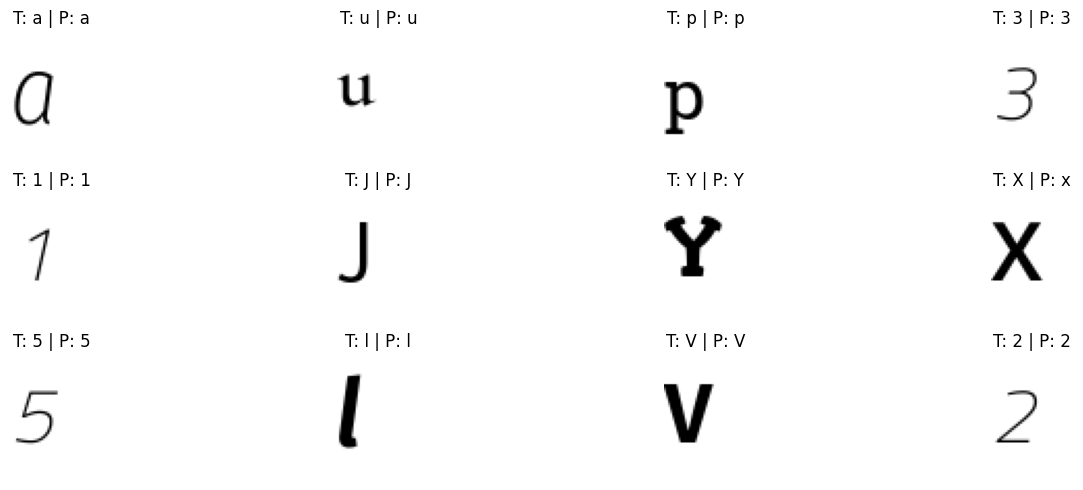

In [ ]:
#Sample predictions
def get_image_path(label, dataset_dir="/content/dataset"):
    # Try uppercase folder
    path_u = os.path.join(dataset_dir, f"{label}_U")
    if os.path.exists(path_u):
        return os.path.join(path_u, os.listdir(path_u)[0])
    # Try lowercase folder
    path_l = os.path.join(dataset_dir, f"{label}_L")
    if os.path.exists(path_l):
        return os.path.join(path_l, os.listdir(path_l)[0])
    # Try digits folder
    path_d = os.path.join(dataset_dir, f"{label}")
    if os.path.exists(path_d):
        return os.path.join(path_d, os.listdir(path_d)[0])
    return None

plt.figure(figsize=(15,5))
sample_indices = np.random.choice(len(X_test), 12, replace=False)

for i, idx in enumerate(sample_indices):
    true_label = y_test[idx]
    pred_label = y_pred[idx]

    img_path = get_image_path(true_label)
    if img_path is None:
        continue
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(3,4,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T: {true_label} | P: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()



# **F1-Score Analysis per Class**

Here, we compute the F1-score for each individual class to evaluate how well the model performs across different characters. The bar chart highlights which classes achieve high recognition performance and which classes are more challenging for the model, providing a more detailed view than overall accuracy alone.

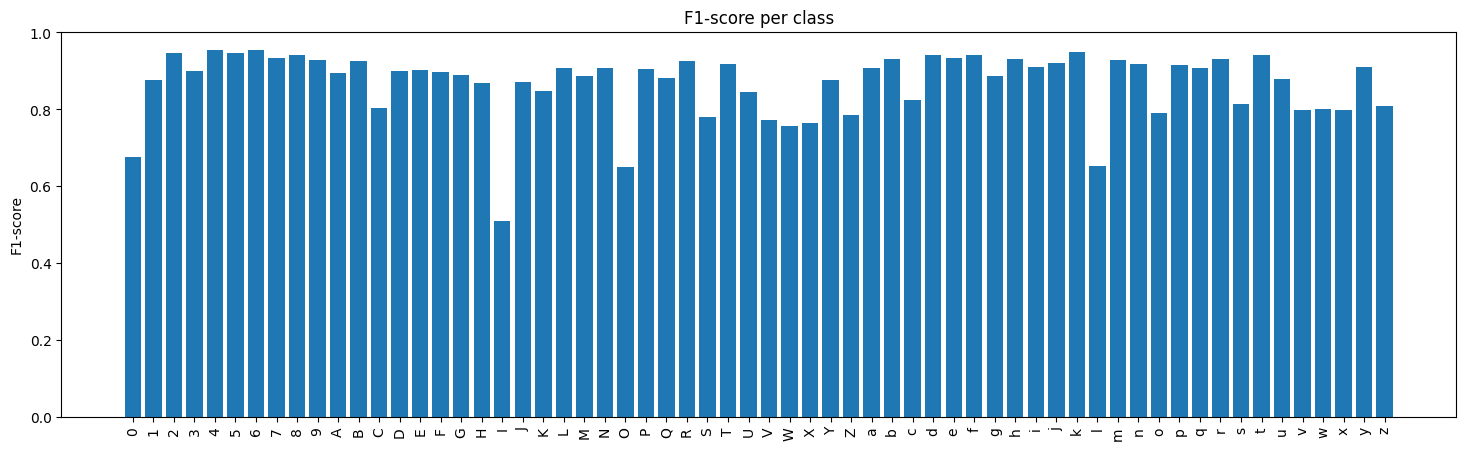

In [ ]:
#F1-score per class
class_report = classification_report(y_test, y_pred, output_dict=True)
class_acc = {k:v['f1-score'] for k,v in class_report.items() if k not in ['accuracy','macro avg','weighted avg']}

plt.figure(figsize=(18,5))
plt.bar(class_acc.keys(), class_acc.values())
plt.xticks(rotation=90)
plt.ylabel("F1-score")
plt.title("F1-score per class")
plt.show()

# **Conclusion**

This notebook presented the complete workflow for building an Optical Character Recognition (OCR) system using machine learning techniques. The process included dataset preparation, image preprocessing, HOG feature extraction, model training with a Support Vector Machine classifier, and comprehensive performance evaluation using accuracy metrics, classification reports, and visualization tools.

The obtained results demonstrate the capability of the model to recognize alphanumeric characters with high accuracy. Future improvements may include experimenting with deep learning models, expanding the dataset, or performing advanced data augmentation to further enhance recognition performance.